Deciding between a celebrity look alike with photo classifier and something slightly easier with gender and race classification

[LFW Website](http://vis-www.cs.umass.edu/lfw/#information) <br />
[LFW Dataset and Other Papers](https://paperswithcode.com/dataset/lfw) <br />
[Tensorflow Documentation](https://www.tensorflow.org/datasets/catalog/lfw) <br />
[CONV2D Explanation](https://towardsdatascience.com/conv2d-to-finally-understand-what-happens-in-the-forward-pass-1bbaafb0b148) <br />
[Image Classification Explanation](https://www.analyticsvidhya.com/blog/2020/02/learn-image-classification-cnn-convolutional-neural-networks-3-datasets/) <br />
[LFW Cleaning Data](https://datagen.tech/guides/image-datasets/lfw-dataset/) 


## Rolling list of links papers that helped me:

[BOLD5000](https://www.nature.com/articles/s41597-019-0052-3) <br />
[HyperParameter Selection](https://ada.liacs.leidenuniv.nl/papers/ShaEtAl19.pdf)<br />
[Activation Functions](https://machinelearningmastery.com/choose-an-activation-function-for-deep-learning/)

## Libraries

In [3]:
#!pip install tensorflow-datasets
#!pip install tensorflow
#!pip install -U jupyter
#!pip install -U  tensorflow
#!pip install -U  sklearn
#!pip install -U -q segmentation-models

#!pip install -q tensorflow==2.1
#!pip install -q keras==2.3.1
#!pip install -q tensorflow-estimator==2.1.
#!pip install tensorflow
#!pip install torch
#!pip install scikeras
#!pip install opencv-python

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
import cv2
import tensorflow as tf
import tensorflow_datasets as tfds
import keras
from sklearn import datasets
from sklearn.model_selection import KFold, GridSearchCV, train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from sklearn.model_selection import cross_val_score
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten, Rescaling
from keras.callbacks import EarlyStopping
#from keras.wrappers.scikit_learn import KerasClassifier

from scikeras.wrappers import KerasClassifier, KerasRegressor
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import requests
import glob
import os
import torch
import shutil

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(os.getcwd())
print('Training on',DEVICE)
seed = 9090

C:\Users\quort\Documents\GitHub\Raphael-San-Andres-Portfolio\[In-Progress] Neural Network for Celebrity Face Classifier (LFW)
Training on cpu


## Loading Dataset

Gonna be using sklearn instead of tfds to download data now.

In [5]:
#example_txt = 'https://www.cs.columbia.edu/CAVE/databases/pubfig/download/lfw_attributes.txt'

#r = requests.get(example_txt)
#with open('lfw_attributes.txt', 'wb') as f:
#    f.write(r.content)

In [6]:
ds = []

DATASET_PATH ="lfw-deepfunneled/"
ATTRIBUTES_PATH = "/lfw_attributes.txt/"

In [7]:
for path in glob.glob(os.path.join(DATASET_PATH ,"**", "*.jpg")):
    person = path.split("\\")[-2]
    ds.append({"person":person, "path": path})

ds = pd.DataFrame(ds)
ds = ds.groupby("person").filter(lambda x: len(x) > 20)
ds.head(10)

,person,path
222,Alejandro_Toledo,lfw-deepfunneled\Alejandro_Toledo\Alejandro_To...
223,Alejandro_Toledo,lfw-deepfunneled\Alejandro_Toledo\Alejandro_To...
224,Alejandro_Toledo,lfw-deepfunneled\Alejandro_Toledo\Alejandro_To...
225,Alejandro_Toledo,lfw-deepfunneled\Alejandro_Toledo\Alejandro_To...
226,Alejandro_Toledo,lfw-deepfunneled\Alejandro_Toledo\Alejandro_To...
227,Alejandro_Toledo,lfw-deepfunneled\Alejandro_Toledo\Alejandro_To...
228,Alejandro_Toledo,lfw-deepfunneled\Alejandro_Toledo\Alejandro_To...
229,Alejandro_Toledo,lfw-deepfunneled\Alejandro_Toledo\Alejandro_To...
230,Alejandro_Toledo,lfw-deepfunneled\Alejandro_Toledo\Alejandro_To...
231,Alejandro_Toledo,lfw-deepfunneled\Alejandro_Toledo\Alejandro_To...


<AxesSubplot:xlabel='person'>

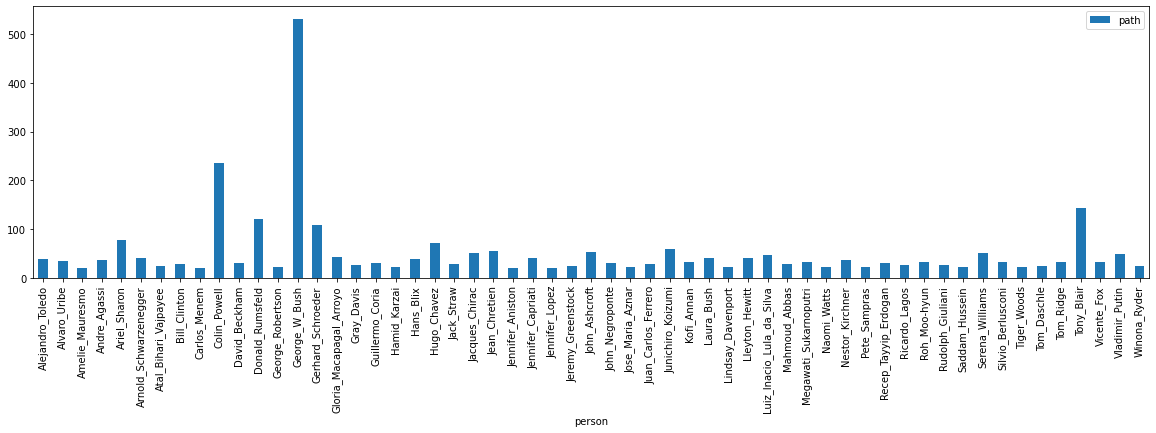

In [8]:
ds.groupby("person").count()[:200].plot(kind='bar', figsize=(20,5))

In [9]:
unique_labels = ds['person'].unique()
d = dict(enumerate(map(str, unique_labels)))
d = dict((v,k) for k,v in d.items())

In [10]:
ds['person_num'] = ds['person'].map(d)
ds

,person,path,person_num
222,Alejandro_Toledo,lfw-deepfunneled\Alejandro_Toledo\Alejandro_To...,0
223,Alejandro_Toledo,lfw-deepfunneled\Alejandro_Toledo\Alejandro_To...,0
224,Alejandro_Toledo,lfw-deepfunneled\Alejandro_Toledo\Alejandro_To...,0
225,Alejandro_Toledo,lfw-deepfunneled\Alejandro_Toledo\Alejandro_To...,0
226,Alejandro_Toledo,lfw-deepfunneled\Alejandro_Toledo\Alejandro_To...,0
...,...,...,...
13042,Winona_Ryder,lfw-deepfunneled\Winona_Ryder\Winona_Ryder_002...,56
13043,Winona_Ryder,lfw-deepfunneled\Winona_Ryder\Winona_Ryder_002...,56
13044,Winona_Ryder,lfw-deepfunneled\Winona_Ryder\Winona_Ryder_002...,56
13045,Winona_Ryder,lfw-deepfunneled\Winona_Ryder\Winona_Ryder_002...,56


## Exploring Data (Using TFDS)

In [28]:
ds, ds_info = tfds.load('lfw',split='train', with_info = True, as_supervised = True )
ds_info.features
#Some preprocessing steps are done as the image is normalized to be 250x250

FeaturesDict({
    'image': Image(shape=(250, 250, 3), dtype=tf.uint8),
    'label': Text(shape=(), dtype=tf.string),
})

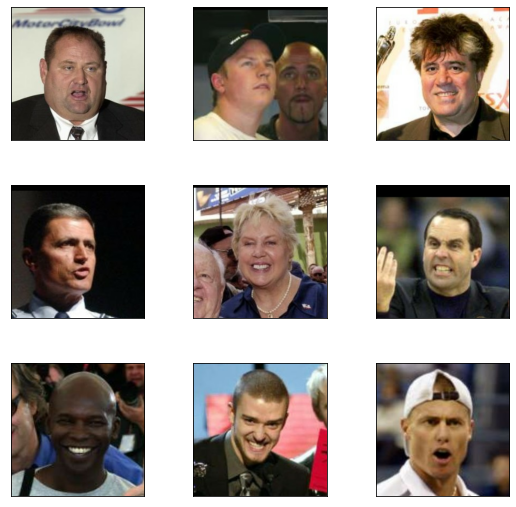

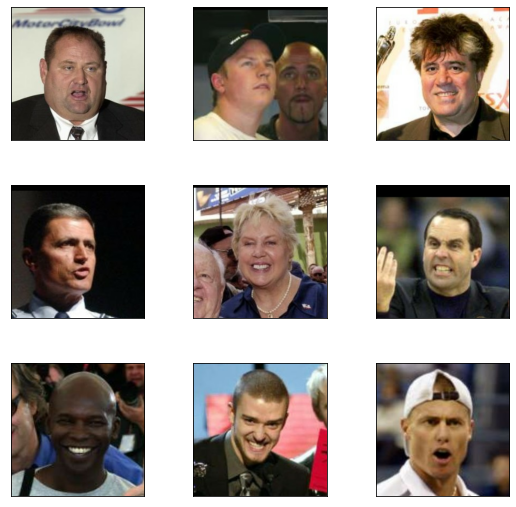

In [29]:
tfds.show_examples(ds, ds_info)

In [30]:
df = tfds.as_dataframe(ds, ds_info)
head = df.head()

In [31]:
head['image']

0    [[[207, 209, 195], [207, 209, 195], [208, 210,...
1    [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...
2    [[[255, 255, 255], [255, 255, 255], [255, 255,...
3    [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...
4    [[[5, 0, 4], [3, 0, 2], [1, 0, 0], [2, 0, 1], ...
Name: image, dtype: object

In [32]:
head['label']

0        b'Tom_Amstutz'
1     b'Kimi_Raikkonen'
2    b'Pedro_Almodovar'
3          b'John_Rosa'
4        b'Jane_Rooney'
Name: label, dtype: object

In [33]:
counts = labels.explode().value_counts()
counts = counts.to_frame()
counts = counts.rename({ "label": "counts"}, axis = 1)
counts.index.name = "label"
counts.reset_index(inplace = True)
counts = counts[counts['counts'] > 5]
counts
#top 311 people have 5+ pictures

NameError: name 'labels' is not defined

In [ ]:
df1 = df[df['label'].isin(counts['label'])]
df1 = df1.reset_index()
df1['label']

In [ ]:
for example in ds:
    label, image = example
    if label == counts['label'][1]:
        print(label)
    break

In [ ]:
df.head()

In [ ]:
labels = df['label']

In [15]:
# train_images = []
# train_labels = []
# i = 0
# #inefficient way of doing it but I wanted to make it work first
# for example in ds:
#     label, image = example
#     for c in counts['label']:
#         i += 1
#         print(i)
#         if label == c:
#             train_images.append(image.numpy())
#             train_labels.append(label.numpy())
#             continue

    

In [16]:
# len(train_images)

In [17]:
# len(train_labels)

## Data Processing

#### other loading methods

In [12]:
#Other data loading method
lfw_train, lfw_test = train_test_split(ds, test_size = 0.2, random_state = seed)
lfw_train, lfw_val =  train_test_split(lfw_train, test_size = 0.2, random_state = seed)
lfw_train = lfw_train.reset_index().drop("index",1)
lfw_test = lfw_test.reset_index().drop("index",1)
print(len(set(lfw_train.person).intersection(set(lfw_test.person))))
print(len(set(lfw_test.person) - set(lfw_train.person)))

#K folds if I want
kfold = KFold(n_splits = 10, shuffle = True, random_state = seed)

57
0


C:\Users\quort\AppData\Local\Temp\ipykernel_19424\586254340.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  lfw_train = lfw_train.reset_index().drop("index",1)
C:\Users\quort\AppData\Local\Temp\ipykernel_19424\586254340.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  lfw_test = lfw_test.reset_index().drop("index",1)


#### loading methods

In [13]:
batch_size = 32
img_height = 250
img_width = 250

In [29]:
#can parse using the old train and getting thier paths
train_ds = tf.keras.utils.image_dataset_from_directory(
  DATASET_PATH,
  validation_split=0.2,
  subset="training",
  seed=seed,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  DATASET_PATH,
  validation_split=0.2,
  subset="validation",
  seed=seed,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 13233 files belonging to 5749 classes.
Using 10587 files for training.
Found 13233 files belonging to 5749 classes.
Using 2646 files for validation.


In [30]:
class_names = train_ds.class_names
class_names_test =val_ds.class_names
classes = len(train_ds.class_names)
print(len(train_ds.class_names))
print(len(val_ds.class_names))

5749
5749


Normally, this step would be done by me but LFW has the following in the README.txt

"Each image is a 250x250 jpg, detected and centered using the openCV implementation of Viola-Jones face detector. The cropping region returned by the detector was then automatically enlarged by a factor of 2.2 in each dimension to capture more of the head and then scaled to a uniform size."

## Modelings

In [17]:
#Performance 
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
#Preliminary Models
#We are working with a 250 x 250 pictures with 3 color channels
#Choosing a simple 1 input layer and 2 hidden layers for now. Will optimize later.
#I will be using relu function for activation,  mean squared error for loss, and adam for optimizer

$$ N_h = \frac{N_s} {(\alpha * (N_i + N_o))} $$
$ Ni $= number of input neurons. <br />
$No$ = number of output neurons.<br />
$Ns$ = number of samples in training data set.<br />
$α $= an arbitrary scaling factor usually 2-10.

[Link](https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw)

[Refreshment on the Math](https://arxiv.org/pdf/1603.07285v1.pdf)

### First model on all data

In [31]:
num_classes = 5749

model = Sequential()
model.add(Rescaling(1./255))
model.add(Conv2D(64, kernel_size = (3,3), activation = 'relu', input_shape = (250,250,3)))
model.add(MaxPool2D(pool_size=(1,1)))
model.add(Conv2D(32, kernel_size = (3,3), activation = 'relu'))
model.add(MaxPool2D(pool_size=(1,1)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(classes, activation='softmax'))
model.compile(optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

In [ ]:
#first try

In [32]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10
)

Epoch 1/10
331/331 [==============================] - 1146s 3s/step - loss: 8.3449 - accuracy: 0.0354 - val_loss: 8.0906 - val_accuracy: 0.0491
Epoch 2/10
331/331 [==============================] - 1162s 4s/step - loss: 7.4334 - accuracy: 0.0380 - val_loss: 8.5511 - val_accuracy: 0.0480
Epoch 3/10
331/331 [==============================] - 1169s 4s/step - loss: 6.9519 - accuracy: 0.0410 - val_loss: 9.1259 - val_accuracy: 0.0431
Epoch 4/10
331/331 [==============================] - 1168s 4s/step - loss: 6.3421 - accuracy: 0.0488 - val_loss: 11.2238 - val_accuracy: 0.0393
Epoch 5/10
331/331 [==============================] - 1173s 4s/step - loss: 5.2542 - accuracy: 0.1080 - val_loss: 14.0210 - val_accuracy: 0.0306
Epoch 6/10
331/331 [==============================] - 1168s 4s/step - loss: 4.0569 - accuracy: 0.2459 - val_loss: 16.6604 - val_accuracy: 0.0189
Epoch 7/10
331/331 [==============================] - 1177s 4s/step - loss: 3.0556 - accuracy: 0.3910 - val_loss: 21.0633 - val_accur

In [33]:
import pickle
pickle.dump(model, open("model1.pkl", "wb"))

INFO:tensorflow:Assets written to: ram://cabccf85-9172-4b3f-ada0-c5d9af8b1be6/assets


INFO:tensorflow:Assets written to: ram://cabccf85-9172-4b3f-ada0-c5d9af8b1be6/assets


In [35]:
#forgot to write callbacks, do it for next time

### Second model on filtered data

In [13]:
ds = ds.reset_index()
ds.iterrows()

<generator object DataFrame.iterrows at 0x0000019EC78FC350>

In [11]:
destination = 'dataset_20plus'
DATASET_PATH ="dataset_20plus/"
ATTRIBUTES_PATH = "/lfw_attributes.txt/"

batch_size = 32
img_height = 250
img_width = 250

for index, item in ds.iterrows():
    path = item['path']
    folder = destination + "/" + str(item['person'])
    if not os.path.exists(folder):
        os.mkdir(destination + "/" + str(item['person']))
    shutil.copy(path, folder)

In [17]:
#can parse using the old train and getting thier paths
train_ds = tf.keras.utils.image_dataset_from_directory(
  DATASET_PATH,
  validation_split=0.2,
  subset="training",
  seed=seed,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  DATASET_PATH,
  validation_split=0.2,
  subset="validation",
  seed=seed,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2923 files belonging to 57 classes.
Using 2339 files for training.
Found 2923 files belonging to 57 classes.
Using 584 files for validation.


In [14]:
num_classes = len(train_ds.class_names)
num_classes

57

In [15]:
model = Sequential()
model.add(Rescaling(1./255))

model.add(Conv2D(64, kernel_size = (3,3), activation = 'relu', input_shape = (250,250,3)))
model.add(MaxPool2D(pool_size=(1,1)))

model.add(Conv2D(32, kernel_size = (3,3), activation = 'relu'))
model.add(MaxPool2D(pool_size=(1,1)))

model.add(Conv2D(32, kernel_size = (3,3), activation = 'relu'))
model.add(MaxPool2D(pool_size=(1,1)))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))
model.compile(optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

In [14]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=5
)
## add callbacks next time

Epoch 1/5
74/74 [==============================] - 279s 4s/step - loss: 10.8225 - accuracy: 0.1009 - val_loss: 4.0136 - val_accuracy: 0.1764
Epoch 2/5
74/74 [==============================] - 280s 4s/step - loss: 3.8215 - accuracy: 0.1838 - val_loss: 3.6707 - val_accuracy: 0.1952
Epoch 3/5
74/74 [==============================] - 278s 4s/step - loss: 3.3957 - accuracy: 0.2245 - val_loss: 3.6713 - val_accuracy: 0.1866
Epoch 4/5
74/74 [==============================] - 273s 4s/step - loss: 1.7398 - accuracy: 0.5703 - val_loss: 4.0717 - val_accuracy: 0.2312
Epoch 5/5
74/74 [==============================] - 270s 4s/step - loss: 0.1914 - accuracy: 0.9517 - val_loss: 4.2370 - val_accuracy: 0.2860


In [15]:
import pickle
pickle.dump(model, open("model2.pkl", "wb"))

##stopped early since it looked like it was overfitting

INFO:tensorflow:Assets written to: ram://bd3557e6-e133-4da8-b9b5-c00b80c1f636/assets


INFO:tensorflow:Assets written to: ram://bd3557e6-e133-4da8-b9b5-c00b80c1f636/assets


### HyperParameter Testing

#### Grid Search (NA due to ineffciencies)

In [11]:
#Stratified to include all classes in each fold
ds = ds.reset_index()
ds.iterrows()
kfold = StratifiedKFold(n_splits = 10, shuffle = True, random_state = seed)

In [12]:
ds.head()

,index,person,path,person_num
0,222,Alejandro_Toledo,lfw-deepfunneled\Alejandro_Toledo\Alejandro_To...,0
1,223,Alejandro_Toledo,lfw-deepfunneled\Alejandro_Toledo\Alejandro_To...,0
2,224,Alejandro_Toledo,lfw-deepfunneled\Alejandro_Toledo\Alejandro_To...,0
3,225,Alejandro_Toledo,lfw-deepfunneled\Alejandro_Toledo\Alejandro_To...,0
4,226,Alejandro_Toledo,lfw-deepfunneled\Alejandro_Toledo\Alejandro_To...,0


In [13]:
destination = 'dataset_20plus'
DATASET_PATH ="dataset_20plus/"
ATTRIBUTES_PATH = "/lfw_attributes.txt/"

batch_size = 32
img_height = 250
img_width = 250

for index, item in ds.iterrows():
    path = item['path']
    folder = destination + "/" + str(item['person'])
    if not os.path.exists(folder):
        os.mkdir(destination + "/" + str(item['person']))
    shutil.copy(path, folder)

In [14]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  DATASET_PATH,
  validation_split=0.2,
  subset="training",
  seed=seed,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  DATASET_PATH,
  validation_split=0.2,
  subset="validation",
  seed=seed,
  image_size=(img_height, img_width),
  batch_size=batch_size)

num_classes = len(train_ds.class_names)

Found 2923 files belonging to 57 classes.
Using 2339 files for training.
Found 2923 files belonging to 57 classes.
Using 584 files for validation.


In [15]:
train_images = []
train_labels = []

for filename in os.listdir(DATASET_PATH):
    for jpg in os.listdir(DATASET_PATH + "/" + filename):
        if jpg.split('.')[1] == 'jpg':
            p = DATASET_PATH + filename  + "/" + jpg 
            train_labels.append(d[filename])
            img = cv2.imread(p)
            train_images.append(img)


In [16]:
datagen = ImageDataGenerator(rescale=1.0/255.0)
dataset = datagen.flow_from_directory(DATASET_PATH, class_mode='categorical')
X, Y = dataset.next()

Found 2923 images belonging to 57 classes.


In [20]:
def simp_create_model(neurons, activation = 'relu'):
    model = tf.keras.models.Sequential()
    #model.add(Rescaling(1./255))
    model.add(Conv2D(neurons, kernel_size = (3,3), activation = 'relu', input_shape = (256,256,3)))
    model.add(MaxPool2D(pool_size=(1,1)))
    model.add(Conv2D(neurons, kernel_size = (3,3), activation = 'relu'))
    model.add(MaxPool2D(pool_size=(1,1)))
    
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
    return model



model1 =KerasClassifier(model=simp_create_model)

params={'model__neurons':[32, 64, 128],
        'batch_size':[32, 64], 
        #"model__activation" : ['relu', 'tanh', 'sigmoid'],
        #"optimizer" :['SGD', 'RMSprop','Adam'],
        "optimizer__learning_rate" :[0.001, 0.01, 0.1],
        'epochs':[5,10,20],
       #"optimizer__momentum" : [0.0, 0.2, 0.4, 0.6],
        #"model__dropout_rate" : [0.0, 0.1, 0.4, 0.6]
        }

#GridSearchCV not scalable with bigger neural networks
#cv = 10 is the same as 10 k folds
grid = GridSearchCV(estimator=model1, param_grid=params, error_score = "raise", verbose = 10)

In [21]:
params

{'model__neurons': [32, 64, 128],
 'batch_size': [32, 64],
 'optimizer__learning_rate': [0.001, 0.01, 0.1],
 'epochs': [5, 10, 20]}

In [22]:
import warnings

grid_result = grid.fit(X, Y)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
[CV 1/5; 1/54] START batch_size=32, epochs=5, model__neurons=32, optimizer__learning_rate=0.001
Epoch 1/5
1/1 [==============================] - 3s 3s/step - loss: 0.6950 - accuracy: 0.0000e+00
Epoch 2/5
1/1 [==============================] - 2s 2s/step - loss: 5.4834 - accuracy: 0.0000e+00
Epoch 3/5
1/1 [==============================] - 2s 2s/step - loss: 1.7238 - accuracy: 0.0800
Epoch 4/5
1/1 [==============================] - 2s 2s/step - loss: 0.9089 - accuracy: 0.0800
Epoch 5/5
1/1 [==============================] - 0s 203ms/step
[CV 1/5; 1/54] END batch_size=32, epochs=5, model__neurons=32, optimizer__learning_rate=0.001;, score=0.000 total time=  13.7s
[CV 2/5; 1/54] START batch_size=32, epochs=5, model__neurons=32, optimizer__learning_rate=0.001
Epoch 1/5
1/1 [==============================] - 3s 3s/step - loss: 0.7086 - accuracy: 0.0000e+00
Epoch 2/5
1/1 [==============================] - 2s 2s/step - loss: 5.6610

Epoch 1/5
1/1 [==============================] - 4s 4s/step - loss: 0.7038 - accuracy: 0.0000e+00
Epoch 2/5
1/1 [==============================] - 2s 2s/step - loss: 3.4500 - accuracy: 0.0000e+00
Epoch 3/5
1/1 [==============================] - 2s 2s/step - loss: 3.0015 - accuracy: 0.0385
Epoch 4/5
1/1 [==============================] - 2s 2s/step - loss: 1.8801 - accuracy: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 250ms/step
[CV 5/5; 2/54] END batch_size=32, epochs=5, model__neurons=32, optimizer__learning_rate=0.01;, score=0.000 total time=  16.8s
[CV 1/5; 3/54] START batch_size=32, epochs=5, model__neurons=32, optimizer__learning_rate=0.1
Epoch 1/5
1/1 [==============================] - 3s 3s/step - loss: 0.6961 - accuracy: 0.0800
Epoch 2/5
1/1 [==============================] - 2s 2s/step - loss: 1.1825 - accuracy: 0.0000e+00
Epoch 3/5
1/1 [==============================] - 2s 2s/step - loss: 1.4935 - accuracy: 0.0000e+00
Epoch 4/5
1/1 [========================

Epoch 1/5
1/1 [==============================] - 7s 7s/step - loss: 0.6861 - accuracy: 0.0000e+00
Epoch 2/5
1/1 [==============================] - 7s 7s/step - loss: 12.5548 - accuracy: 0.0000e+00
Epoch 3/5
1/1 [==============================] - 6s 6s/step - loss: 5.6391 - accuracy: 0.0400
Epoch 4/5
1/1 [==============================] - 5s 5s/step - loss: 3.8956 - accuracy: 0.0400
Epoch 5/5
1/1 [==============================] - 0s 469ms/step
[CV 1/5; 5/54] END batch_size=32, epochs=5, model__neurons=64, optimizer__learning_rate=0.01;, score=0.000 total time=  38.8s
[CV 2/5; 5/54] START batch_size=32, epochs=5, model__neurons=64, optimizer__learning_rate=0.01
Epoch 1/5
1/1 [==============================] - 23s 23s/step - loss: 0.6933 - accuracy: 0.0000e+00
Epoch 2/5
1/1 [==============================] - 13s 13s/step - loss: 8.5886 - accuracy: 0.0400
Epoch 3/5
1/1 [==============================] - 4s 4s/step - loss: 1.7953 - accuracy: 0.0800
Epoch 4/5
1/1 [==========================

Epoch 1/5
1/1 [==============================] - 84s 84s/step - loss: 0.6964 - accuracy: 0.0000e+00
Epoch 2/5
1/1 [==============================] - 104s 104s/step - loss: 12.5041 - accuracy: 0.0400
Epoch 3/5


ResourceExhaustedError: Graph execution error:

Detected at node 'Adam/Adam/update_4/ResourceApplyAdam' defined at (most recent call last):
    File "C:\Users\quort\anaconda3\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\quort\anaconda3\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\quort\anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "C:\Users\quort\anaconda3\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
      app.start()
    File "C:\Users\quort\anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 677, in start
      self.io_loop.start()
    File "C:\Users\quort\anaconda3\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\quort\anaconda3\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "C:\Users\quort\anaconda3\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "C:\Users\quort\anaconda3\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\quort\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 471, in dispatch_queue
      await self.process_one()
    File "C:\Users\quort\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 460, in process_one
      await dispatch(*args)
    File "C:\Users\quort\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 367, in dispatch_shell
      await result
    File "C:\Users\quort\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 662, in execute_request
      reply_content = await reply_content
    File "C:\Users\quort\anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 360, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "C:\Users\quort\anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 532, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\quort\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2863, in run_cell
      result = self._run_cell(
    File "C:\Users\quort\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2909, in _run_cell
      return runner(coro)
    File "C:\Users\quort\anaconda3\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\quort\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3106, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\quort\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3309, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\quort\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3369, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\quort\AppData\Local\Temp\ipykernel_16364\1339918085.py", line 3, in <cell line: 3>
      grid_result = grid.fit(X, Y)
    File "C:\Users\quort\anaconda3\lib\site-packages\sklearn\model_selection\_search.py", line 891, in fit
      self._run_search(evaluate_candidates)
    File "C:\Users\quort\anaconda3\lib\site-packages\sklearn\model_selection\_search.py", line 1392, in _run_search
      evaluate_candidates(ParameterGrid(self.param_grid))
    File "C:\Users\quort\anaconda3\lib\site-packages\sklearn\model_selection\_search.py", line 838, in evaluate_candidates
      out = parallel(
    File "C:\Users\quort\anaconda3\lib\site-packages\joblib\parallel.py", line 1046, in __call__
      while self.dispatch_one_batch(iterator):
    File "C:\Users\quort\anaconda3\lib\site-packages\joblib\parallel.py", line 861, in dispatch_one_batch
      self._dispatch(tasks)
    File "C:\Users\quort\anaconda3\lib\site-packages\joblib\parallel.py", line 779, in _dispatch
      job = self._backend.apply_async(batch, callback=cb)
    File "C:\Users\quort\anaconda3\lib\site-packages\joblib\_parallel_backends.py", line 208, in apply_async
      result = ImmediateResult(func)
    File "C:\Users\quort\anaconda3\lib\site-packages\joblib\_parallel_backends.py", line 572, in __init__
      self.results = batch()
    File "C:\Users\quort\anaconda3\lib\site-packages\joblib\parallel.py", line 262, in __call__
      return [func(*args, **kwargs)
    File "C:\Users\quort\anaconda3\lib\site-packages\joblib\parallel.py", line 262, in <listcomp>
      return [func(*args, **kwargs)
    File "C:\Users\quort\anaconda3\lib\site-packages\sklearn\utils\fixes.py", line 216, in __call__
      return self.function(*args, **kwargs)
    File "C:\Users\quort\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
      estimator.fit(X_train, y_train, **fit_params)
    File "C:\Users\quort\anaconda3\lib\site-packages\scikeras\wrappers.py", line 1494, in fit
      super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
    File "C:\Users\quort\anaconda3\lib\site-packages\scikeras\wrappers.py", line 762, in fit
      self._fit(
    File "C:\Users\quort\anaconda3\lib\site-packages\scikeras\wrappers.py", line 931, in _fit
      self._fit_keras_model(
    File "C:\Users\quort\anaconda3\lib\site-packages\scikeras\wrappers.py", line 526, in _fit_keras_model
      hist = self.model_.fit(x=X, y=y, **fit_args)
    File "C:\Users\quort\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\quort\anaconda3\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\quort\anaconda3\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "C:\Users\quort\anaconda3\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\quort\anaconda3\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "C:\Users\quort\anaconda3\lib\site-packages\keras\engine\training.py", line 997, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "C:\Users\quort\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 579, in minimize
      return self.apply_gradients(grads_and_vars, name=name)
    File "C:\Users\quort\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 738, in apply_gradients
      return tf.__internal__.distribute.interim.maybe_merge_call(
    File "C:\Users\quort\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 797, in _distributed_apply
      update_op = distribution.extended.update(
    File "C:\Users\quort\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 776, in apply_grad_to_update_var
      update_op = self._resource_apply_dense(grad, var, **apply_kwargs)
    File "C:\Users\quort\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py", line 177, in _resource_apply_dense
      return tf.raw_ops.ResourceApplyAdam(
Node: 'Adam/Adam/update_4/ResourceApplyAdam'
OOM when allocating tensor with shape[8128512,128] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu
	 [[{{node Adam/Adam/update_4/ResourceApplyAdam}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_34332]

In [183]:
def create_model(neurons,dropout_rate, optimizer = 'adam', activation = 'relu'):
    model = Sequential()
    model.add(Rescaling(1./255))
    model.add(Conv2D(neurons, kernel_size = (3,3), activation = activation, input_shape = (250,250,3)))
    model.add(MaxPool2D(pool_size=(1,1)))
    model.add(Conv2D(neurons, kernel_size = (3,3), activation = activation))
    model.add(MaxPool2D(pool_size=(1,1)))
    model.add(Conv2D(neurons, kernel_size = (3,3), activation = activation))
    model.add(MaxPool2D(pool_size=(1,1)))
    model.add(Dropout(dropout_rate))
    model.add(Flatten())
    model.add(Dense(128, activation=activation)) 
    model.add(Dense(64, activation=activation)) 
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model



model=KerasClassifier(model=create_model, verbose = 2)

params={'model__neurons':[16, 32, 64, 128],
        'batch_size':[16, 32, 64, 128], 
        "model__activation" : ['relu', 'tanh', 'sigmoid'],
        "optimizer" :['SGD', 'RMSprop','Adam'],
        "optimizer__learning_rate" :[0.001, 0.01, 0.1],
        'epochs':[5,10,20],
        "optimizer__momentum" : [0.0, 0.2, 0.4, 0.6],
        "model__dropout_rate" : [0.0, 0.1, 0.2, 0.4, 0.6]
        }

#GridSearchCV not scalable with bigger neural networks
#cv = 10 is the same as 10 k folds
grid = GridSearchCV(estimator=model, param_grid=params, n_jobs=1, cv=3, verbose =1, error_score = "raise")

In [186]:
import warnings
#took 36 hours
#grid_result = grid.fit(X, Y)

In [ ]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

## Load Dataset (OLD)

In [3]:
ds, ds_info = tfds.load('lfw',split='train', with_info = True, as_supervised = True )
test =  (ds, ds_info)
ds_info

tfds.core.DatasetInfo(
    name='lfw',
    full_name='lfw/0.1.0',
    description="""
    Labeled Faces in the Wild:
            A Database for Studying Face Recognition in
            Unconstrained Environments
    """,
    homepage='http://vis-www.cs.umass.edu/lfw',
    data_path='~\\tensorflow_datasets\\lfw\\0.1.0',
    file_format=tfrecord,
    download_size=172.20 MiB,
    dataset_size=180.28 MiB,
    features=FeaturesDict({
        'image': Image(shape=(250, 250, 3), dtype=tf.uint8),
        'label': Text(shape=(), dtype=tf.string),
    }),
    supervised_keys=('label', 'image'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=13233, num_shards=2>,
    },
    citation="""@TechReport{LFWTech,
        author = {Gary B. Huang and Manu Ramesh and Tamara Berg and Erik Learned-Miller},
        title = {Labeled Faces in the Wild: A Database for Studying Face Recognition in Unconstrained Environments},
        institution = {University of Massachusetts,

## Data Processing (OLD) [Description inside]

This consists of the old data processing that I conducted. I originally downloaded the dataset from TFDS and used that dataset to explore and produce modeling. However, after some many hours trying to input the data into the CNN, I eventually decided to use an actual dataset within my computer instead of the TFDS dataset. There are some reasons why TFDS made it hard to use. 

**New Method:** Download the dataset and keep them within local files instead of downloading the dataset via TFDS.

1. TFDS downloaded the dataset as a tfds dataset which meant I was working with a PrefetchDataset instead of a more normalized version
2. Editing a TensorSpec proved to be difficult. When attempting to use .map and a dictionary to convert the byte values of the labels (strings which of the individual persons), tensorflow would go into graph mode and block all numpy functionalities to work.
3. Since I was having difficulty sectioning the labels, the model would not work with a string output instead of a categorical integer
4. I did not tackle the sectioning of the dataset either. So, even if I were to run the model, some people with <5 pictures would be included and would not have been helpful for identification. 

In [21]:
unique_labels = df['label'].unique()
d = dict(enumerate(map(str, unique_labels)))
d = dict((v,k) for k,v in d.items())
d

{"b'Tom_Amstutz'": 0,
 "b'Kimi_Raikkonen'": 1,
 "b'Pedro_Almodovar'": 2,
 "b'John_Rosa'": 3,
 "b'Jane_Rooney'": 4,
 "b'Mike_Brey'": 5,
 "b'Keith_Brown'": 6,
 "b'Justin_Timberlake'": 7,
 "b'Lleyton_Hewitt'": 8,
 "b'Thomas_Wilkens'": 9,
 "b'Ian_Thorpe'": 10,
 "b'Christine_Todd_Whitman'": 11,
 "b'Yekaterina_Guseva'": 12,
 "b'George_W_Bush'": 13,
 "b'Martha_Stewart'": 14,
 "b'Jesse_James'": 15,
 "b'John_Abizaid'": 16,
 "b'Tim_Henman'": 17,
 "b'Pieter_Bouw'": 18,
 "b'Lance_Armstrong'": 19,
 "b'John_Marburger'": 20,
 "b'Al_Gore'": 21,
 "b'Donald_Rumsfeld'": 22,
 "b'Andy_Roddick'": 23,
 "b'Jeremy_Greenstock'": 24,
 "b'Junko_Tabei'": 25,
 "b'Richard_Haass'": 26,
 "b'Paul_Coppin'": 27,
 "b'Dinah_Turner'": 28,
 "b'Guenter_Verheugen'": 29,
 "b'Princess_Elisabeth'": 30,
 "b'Doug_Collins'": 31,
 "b'Larry_Hahn'": 32,
 "b'Natalie_Cole'": 33,
 "b'Valery_Giscard_dEstaing'": 34,
 "b'Gregory_Hines'": 35,
 "b'Mitt_Romney'": 36,
 "b'Ahmed_Chalabi'": 37,
 "b'Lucio_Gutierrez'": 38,
 "b'Bridgette_Wilson-Sampr

In [100]:
#had to do it without filtering to see if it works
train_ds, val_ds, test_ds= tfds.load('lfw', split=['train[:70%]', 'train[70%:85%]', 'train[85%:]'], as_supervised = True)

labels = []
for label, image in train_ds:
    #labels.append(float(d[str(label.numpy())]))
    #print(float(d[str(label.numpy())]))
    print(label)
    break
train_ds

tf.Tensor(b'Tom_Amstutz', shape=(), dtype=string)


<PrefetchDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(250, 250, 3), dtype=tf.uint8, name=None))>

In [106]:
print(list(d.keys()))

["b'Tom_Amstutz'", "b'Kimi_Raikkonen'", "b'Pedro_Almodovar'", "b'John_Rosa'", "b'Jane_Rooney'", "b'Mike_Brey'", "b'Keith_Brown'", "b'Justin_Timberlake'", "b'Lleyton_Hewitt'", "b'Thomas_Wilkens'", "b'Ian_Thorpe'", "b'Christine_Todd_Whitman'", "b'Yekaterina_Guseva'", "b'George_W_Bush'", "b'Martha_Stewart'", "b'Jesse_James'", "b'John_Abizaid'", "b'Tim_Henman'", "b'Pieter_Bouw'", "b'Lance_Armstrong'", "b'John_Marburger'", "b'Al_Gore'", "b'Donald_Rumsfeld'", "b'Andy_Roddick'", "b'Jeremy_Greenstock'", "b'Junko_Tabei'", "b'Richard_Haass'", "b'Paul_Coppin'", "b'Dinah_Turner'", "b'Guenter_Verheugen'", "b'Princess_Elisabeth'", "b'Doug_Collins'", "b'Larry_Hahn'", "b'Natalie_Cole'", "b'Valery_Giscard_dEstaing'", "b'Gregory_Hines'", "b'Mitt_Romney'", "b'Ahmed_Chalabi'", "b'Lucio_Gutierrez'", "b'Bridgette_Wilson-Sampras'", "b'Tom_Daschle'", "b'Jean_Carnahan'", "b'Megawati_Sukarnoputri'", "b'Tony_Blair'", "b'John_Allen_Muhammad'", "b'Jose_Viegas_Filho'", "b'Andres_Pastrana'", "b'Kofi_Annan'", "b'Howa

In [118]:
keys_tensor = tf.constant(list(d.keys()))
vals_tensor = tf.constant(list(d.values()))
table = tf.lookup.StaticHashTable(
    tf.lookup.KeyValueTensorInitializer(keys_tensor, vals_tensor),
    default_value=-1)
print(train_ds)

<PrefetchDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(250, 250, 3), dtype=tf.uint8, name=None))>


In [183]:
def convert(label, image):
    image = tf.image.convert_image_dtype(image, tf.float32)
    image, label = convert2(label, image)
    return image, label

def convert2(image, label):
    #label = tf.reshape( label, ( 1, ) )
    label = table.lookup(label)
    #label = tf.reshape( label, () )
    return image, label

In [189]:
a, b = train_ds_1.element_spec
b

TensorSpec(shape=(None,), dtype=tf.int32, name=None)

In [185]:
train_ds_1.element_spec =train_ds_1.element_spec.map(convert2)

AttributeError: 'tuple' object has no attribute 'map'

In [166]:
BATCH_SIZE = 32

train_ds_1 = (train_ds
            .cache()
            .map(convert1)
            .batch(BATCH_SIZE))

val_ds_1 = (val_ds
            .cache()
            .map(convert1)
            .batch(BATCH_SIZE))


Tensor("args_1:0", shape=(250, 250, 3), dtype=uint8)
Tensor("Reshape:0", shape=(1,), dtype=string)


AttributeError: in user code:

    File "<ipython-input-139-97495c169150>", line 4, in convert1  *
        image, label = convert2(label, image)
    File "<ipython-input-165-48b711af6d37>", line 9, in convert2  *
        print(table.lookup(label).numpy())

    AttributeError: 'Tensor' object has no attribute 'numpy'


In [164]:
for i,j in train_ds_1.take(1):
    print(i)
    print(j)

tf.Tensor(
[[[[0.8117648  0.8196079  0.76470596]
   [0.8117648  0.8196079  0.76470596]
   [0.81568635 0.8235295  0.7686275 ]
   ...
   [0.8431373  0.854902   0.78823537]
   [0.8431373  0.854902   0.78823537]
   [0.8431373  0.854902   0.78823537]]

  [[0.8117648  0.8196079  0.76470596]
   [0.8117648  0.8196079  0.76470596]
   [0.81568635 0.8235295  0.7686275 ]
   ...
   [0.8431373  0.854902   0.78823537]
   [0.8431373  0.854902   0.78823537]
   [0.8431373  0.854902   0.78823537]]

  [[0.8117648  0.8196079  0.76470596]
   [0.8117648  0.8196079  0.76470596]
   [0.81568635 0.8235295  0.7686275 ]
   ...
   [0.8431373  0.854902   0.78823537]
   [0.8431373  0.854902   0.78823537]
   [0.8431373  0.854902   0.78823537]]

  ...

  [[0.11764707 0.1137255  0.09803922]
   [0.1137255  0.10980393 0.09411766]
   [0.1137255  0.10980393 0.09411766]
   ...
   [0.09411766 0.08627451 0.09019608]
   [0.09019608 0.08235294 0.08627451]
   [0.09019608 0.08235294 0.08627451]]

  [[0.11764707 0.1137255  0.098039